## Recreating Big Grains plots
This notebook recreates the modelling plot from Stevenson et al (2015) _Big Grains Go Far_ to demonstrate the Python modelling code and to generate data to put results from real grains into context.

In [2]:
import sys
print(sys.path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb
from textwrap import dedent
%matplotlib inline

import os
# Assume that notebook was launched from within project root
examples_dir = './examples'


from tephrange import density, fall_velocity, particle

['/home/jsteven5/GitHub/tephrange/examples', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/jsteven5/.virtualenvs/tephrange/lib/python3.8/site-packages', '/home/jsteven5/GitHub/tephrange', '/home/jsteven5/.virtualenvs/tephrange/lib/python3.8/site-packages/IPython/extensions', '/home/jsteven5/.ipython']


## Compare Ganser versus Stokes' terminal velocities

,DiameterMeters,DensityBP2003,VelocityStokes,VelocityGanserBP2003,StokesOverGanserBP2003
DiameterMicrons,,,,,
20,0.00002,1984.696564,0.027963,0.020818,1.343196
40,0.00004,1752.196564,0.111853,0.069252,1.615155
60,0.00006,1616.192783,0.251669,0.132875,1.894037
80,0.00008,1519.696564,0.447412,0.203706,2.196361
100,0.00010,1444.848282,0.699082,0.277043,2.523366
120,0.00012,1383.692783,1.006677,0.350323,2.873568
140,0.00014,1331.986545,1.370200,0.422222,3.245212
160,0.00016,1287.196564,1.789649,0.492095,3.636798
180,0.00018,1247.689001,2.265024,0.559662,4.047128


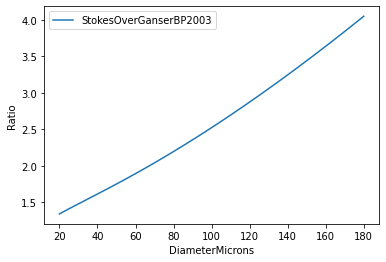

In [3]:
# Set up dataframe for results
d_microns = np.arange(20, 181, 1)
d = d_microns / 1e6
df = pd.DataFrame({'DiameterMeters': d}, index=pd.Series(d_microns, name='DiameterMicrons'))

# Add density column
df['DensityBP2003'] = df['DiameterMeters'].map(lambda x: density.bp2003(x))

# Calculate velocities
df['VelocityStokes'] = df.index.map(lambda x: fall_velocity.stokes(
    diameter=df.loc[x, 'DiameterMeters'], density=2300))
df['VelocityGanserBP2003'] = df.index.map(lambda x: fall_velocity.ganser(
    diameter=df.loc[x, 'DiameterMeters'], density=df.loc[x, 'DensityBP2003'],
    sphericity=0.7))

# Calculate ratio
df['StokesOverGanserBP2003'] = df['VelocityStokes'] / df['VelocityGanserBP2003']

# Show results
ax = df.plot(y='StokesOverGanserBP2003')
ax.set_ylabel('Ratio')
df.loc[::20]  # Every 20th row

## Recreate Big Grains plot

#### Set up distance calculation functions

In [4]:
def stokes_sealevel_distance(diameter, density):
    """
    Calculate travel distance using Stokes' law at sea level.
    """
    p = particle.Particle(diameter=diameter, particle_density=density)
    distance = p.calculate_distance(velocity_function='stokes_sea_level')
    return distance

def ganser_distance(diameter, sphericity, density):
    """
    Calculate travel distance using Ganser with shape factor 0.7
    and variable atmosphere.
    """
    p = particle.Particle(diameter=diameter, sphericity=sphericity,
                          particle_density=density)
    distance = p.calculate_distance(velocity_function='ganser')
    return distance

#### Set up dataframe for results

In [5]:
d_microns = np.arange(20, 181, 1)
d = d_microns / 1e6
df = pd.DataFrame({'DiameterMeters': d}, index=pd.Series(d_microns, name='DiameterMicrons'))
df['DensityBP2003'] = df['DiameterMeters'].map(lambda x: density.bp2003(x))

#### Calculate travel distance using different functions

In [12]:
# Stokes' sea level is calculated with constant density
df['StokesSeaLevel'] = df.index.map(lambda x: stokes_sealevel_distance(
        diameter=df.loc[x, 'DiameterMeters'], density=2300))
# Ganser uses density calculated using Bonadonna and Philips
df['GanserBP2003'] = df.index.map(lambda x: ganser_distance(
        diameter=df.loc[x, 'DiameterMeters'],
        sphericity=0.7,
        density=df.loc[x, 'DensityBP2003']))


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [11]:
# Add Ash Hollow distance information from Riley et al 2003
ash_hollow = pd.read_csv('../examples/Riley2003_Hollow_sphdiam_10km_ws10.csv',
                         sep=' ', names=['DiameterMicrons', 'AshHollow'],
                         index_col='DiameterMicrons')
df = df.join(ash_hollow)

#### Display table to compare distances

In [ ]:
df.loc[np.isfinite(df['AshHollow']), :]

#### Export data to csv

In [ ]:
df.to_csv(os.path.join(data_dir, 'big_grains_plot_data.csv'), index=True)

#### Recreate plot

In [ ]:
ax = df.plot(y='StokesSeaLevel')
df.plot(y='GanserBP2003', ax=ax)
ax.scatter(x=df.index, y=df['AshHollow'], label='AshHollow')
ax.set_xlim(0, 180)
ax.set_ylim(0, 3000)
locations = {'Vienna, Austria': 2750, 'London, UK': 1767, 'Faroe Islands': 660}
for location in locations.keys():
    plt.hlines(locations.get(location), min(plt.xlim()), max(plt.xlim()),
               color='grey')
    x = min(plt.xlim()) + 0.98 * (max(plt.xlim()) - min(plt.xlim()))
    plt.text(x, locations.get(location)+50, location,
             horizontalalignment='right', verticalalignment='bottom',
             color='black')
ax.set_ylabel('Travel distance (km)')
ax.legend(scatterpoints=1)
ax.grid(axis='x')

'/home/jsteven5/GitHub/tephrange/src/__file__'